In [1]:
import sys  
sys.version

'3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]'

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train = pd.read_csv('train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(train.shape)

(42000, 785)


Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.The total number of labels is 10 (0~9)<br/>
We have those usefull parameters as bellow

In [11]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 10000 # Validation data size

STEPS = 3500 #20000   # Number of steps to run
BATCH = 100 # Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 8 #32 # Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 100 #1024 # Number of hidden neurons in the fully connected layer

LR = 0.001 # Learning rate

## Prepering data
- 1-hot label : 1= [1,0,0...,0],2=[0,1,0...,0]....
- reshaping into image size
- splitting data into train and validation set

In [12]:
labels = np.array(train.pop('label')) # Remove the labels as a numpy array from the dataframe
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()
train = StandardScaler().fit_transform(np.float32(train.values)) # Convert the dataframe to a numpy array
train = train.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
train_data, valid_data = train[:-VALID], train[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(labels.shape) + ' = (TRAIN, LABELS)')

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


## Model

Identify the convolutional neural network.Here we use 2 layers to see the results

In [13]:
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

In [14]:
w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))
w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))
w3 = tf.Variable(tf.truncated_normal([WIDTH // 4 * WIDTH // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2*DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

In [15]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), labels=tf_labels))
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

#tf_opt = tf.train.GradientDescentOptimizer(LR)
#tf_opt = tf.train.AdamOptimizer(LR)
tf_opt = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opt.minimize(tf_loss)

## Train

run session

In [16]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [17]:
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

C:\Users\yinghe\anaconda3.5\lib\site-packages\sklearn\model_selection\_split.py:1630: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Step 500 	 Valid. Acc. = 96.550003
Step 1000 	 Valid. Acc. = 97.639999
Step 1500 	 Valid. Acc. = 97.759995
Step 2000 	 Valid. Acc. = 98.180000
Step 2500 	 Valid. Acc. = 98.629997
Step 3000 	 Valid. Acc. = 98.259995
Step 3500 	 Valid. Acc. = 98.509995


Visualize the training history:

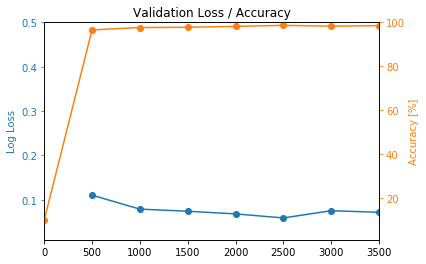

In [21]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

Learning rate should be bigger than what we have set

## Prediction

Label Prediction: 2


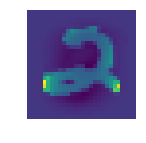

In [23]:
test = pd.read_csv('test.csv') 
test_data = StandardScaler().fit_transform(np.float32(test.values))
test_data = test_data.reshape(-1, WIDTH, WIDTH, CHANNELS) 
test_pred = session.run(tf_pred, feed_dict={tf_data:test_data})
test_labels = np.argmax(test_pred, axis=1)
# k = 0 # Try different image indices k
# print("Label Prediction: %i"%test_labels[k])
# fig = plt.figure(figsize=(2,2)); plt.axis('off')
# plt.imshow(test_data[k,:,:,0]); plt.show()

In [24]:
submission = pd.DataFrame(data={'ImageId':(np.arange(test_labels.shape[0])+1), 'Label':test_labels})
submission.to_csv('submission.csv', index=False)
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [25]:
session.close()

In [ ]:
#![results](1.png)